# Activation Maximization Technique

References:
* http://laid.delanover.com/introduction-to-activation-maximization-and-implementation-in-tensorflow/
* https://towardsdatascience.com/every-ml-engineer-needs-to-know-neural-network-interpretability-afea2ac0824e
* https://arxiv.org/pdf/1904.08939.pdf

**This is a technique to interpret the network from inside and not the output itself.**

Activation maximization, as the name indicates, aims to maximize the activation of certain neurons. Imagine you are training your model with a single image several times. Training is changing the weights accordingly to achieve the lowest loss possible, so the input and the desired output will be constant whereas the weights will be modified iteratively until we reach a minima (or until we decide to stop training). **In Activation Maximization, we will keep the weights and the desired output constant and we will modify the input such that it maximizes certain neurons.**

A network’s activation function output represents how confident it is that a training example belongs to one specific class, and so activation maximization constructs an image that checks off every single box the neural network is looking for and hence yields the largest activation function. This is done with gradient ascent, which tries to maximize the output neuron. **The idea of activation maximization is really just finding the inputs that return an output with the highest confidence.**

<img src="https://miro.medium.com/max/720/1*sAm6DoP7jzc0dn_Fpc-IEw.png" width="600">

The results are really a quite enlightening vision into how the model makes decisions; dark regions represent ‘penalizations’ in that high values in that region make the model less sure the input is that digit, and bright values represent ‘bonuses’ in that high values in those regions increase the confidence of the output neuron. Activation maximization can also be visualized in the form of a distribution or another distribution representation for one-dimensional, non-image data.

**Gradient Ascent algorithm** (Also used on Deep Dream technique)

When creating DeepDream images, the idea is to modify input image so as to maximize the activation of a specific feature map or maps. It's like asking the neural network what it wants to see as input. Neural network itself guides the input modification process.

While training neural networks, we aim to decrease loss and use gradient descent for this purpose. To maximize an activation, we use gradient ascent.

The gradient ascent method advances in the direction of the gradient at each step. The gradient is assessed beginning at point P0, and the function proceeds to the next point, P1. The function then advances to P2 when the gradient is reevaluated at P1. This loop will continue until a stopping condition is fulfilled. The gradient operator always ensures that we are travelling in the best direction feasible.



## Tensorflow General configs and imports


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd 
import numpy as np
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Imports

In [2]:
#Imports necessary
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
import cv2, os, shutil, math
from tensorflow import keras
import matplotlib.gridspec as gridspec
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pathlib

## Data pre-processing

In [3]:
# Obtain and prepare dataset

data_dir = pathlib.Path('../input/monkeypoxdataset/MonkeypoxSkinDataset')

# Input size Final
batch_size = 32
IMG_SIZE = (124,124)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

Found 42350 files belonging to 6 classes.
Using 33880 files for training.
Found 42350 files belonging to 6 classes.
Using 8470 files for validation.


In [4]:
train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

val_batches = val_ds.cardinality().numpy()
test_ds = val_ds.take(val_batches // 3) 
val_ds = val_ds.skip(val_batches // 3)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Transfer Learning on Xception model


In [5]:
# create the base pre-trained model
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

83697664/83683744 [==============================] - 1s 0us/step


In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# this is the model we will train
xception_model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Load model if already trained
# Ignore warning "Could not open.." - it will work even with that message

xception_model.load_weights('../input/xceptionmodeltf/xceptionmodeltfv2')

In [9]:
# Even if you load an already trained model in cell above you need to compile it as well

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

xception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [10]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [11]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 117s 102ms/step - loss: 0.3508 - accuracy: 0.8814 - val_loss: 0.4083 - val_accuracy: 0.8536
Epoch 2/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.3374 - accuracy: 0.8853 - val_loss: 0.3961 - val_accuracy: 0.8566
Epoch 3/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.3222 - accuracy: 0.8903 - val_loss: 0.3858 - val_accuracy: 0.8590
Epoch 4/10
1059/1059 [==============================] - 37s 34ms/step - loss: 0.3091 - accuracy: 0.8945 - val_loss: 0.3776 - val_accuracy: 0.8624
Epoch 5/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2981 - accuracy: 0.8983 - val_loss: 0.3711 - val_accuracy: 0.8636
Epoch 6/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2886 - accuracy: 0.9016 - val_loss: 0.3658 - val_accuracy: 0.8677
Epoch 7/10
1059/1059 [==============================] - 37s 34ms/step - loss: 0.2804 - accuracy: 0.9043 - val_loss: 0.3615

In [12]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2560 - accuracy: 0.9124 - val_loss: 0.3509 - val_accuracy: 0.8727
Epoch 2/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2514 - accuracy: 0.9137 - val_loss: 0.3494 - val_accuracy: 0.8744
Epoch 3/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2471 - accuracy: 0.9152 - val_loss: 0.3482 - val_accuracy: 0.8744
Epoch 4/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.2432 - accuracy: 0.9168 - val_loss: 0.3472 - val_accuracy: 0.8750
Epoch 5/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2396 - accuracy: 0.9179 - val_loss: 0.3464 - val_accuracy: 0.8751
Epoch 6/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2363 - accuracy: 0.9192 - val_loss: 0.3458 - val_accuracy: 0.8758
Epoch 7/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2332 - accuracy: 0.9201 - val_loss: 0.3454 -

In [13]:
#Save the previous trained model

modelSaving = xception_model.save_weights('./xceptionmodel', save_format='h5')

In [14]:
#test sample evaluation

score = xception_model.evaluate(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

88/88 [==============================] - 3s 29ms/step - loss: 0.3180 - accuracy: 0.8903
Test loss:  0.3180127441883087
Test accuracy:  0.8902698755264282


## Implementing Activation Maximization

keras implementation: https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [15]:
# The dimensions of our input image
img_width = 180
img_height = 180

# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
# This will change every run
layer_name = "add_11" 

In [16]:
# Set up a model that returns the activation values for our target layer
layer = xception_model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=xception_model.inputs, outputs=layer.output)

In [17]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [18]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [19]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [20]:
loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

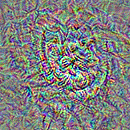

In [21]:
display(Image("0.png"))

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

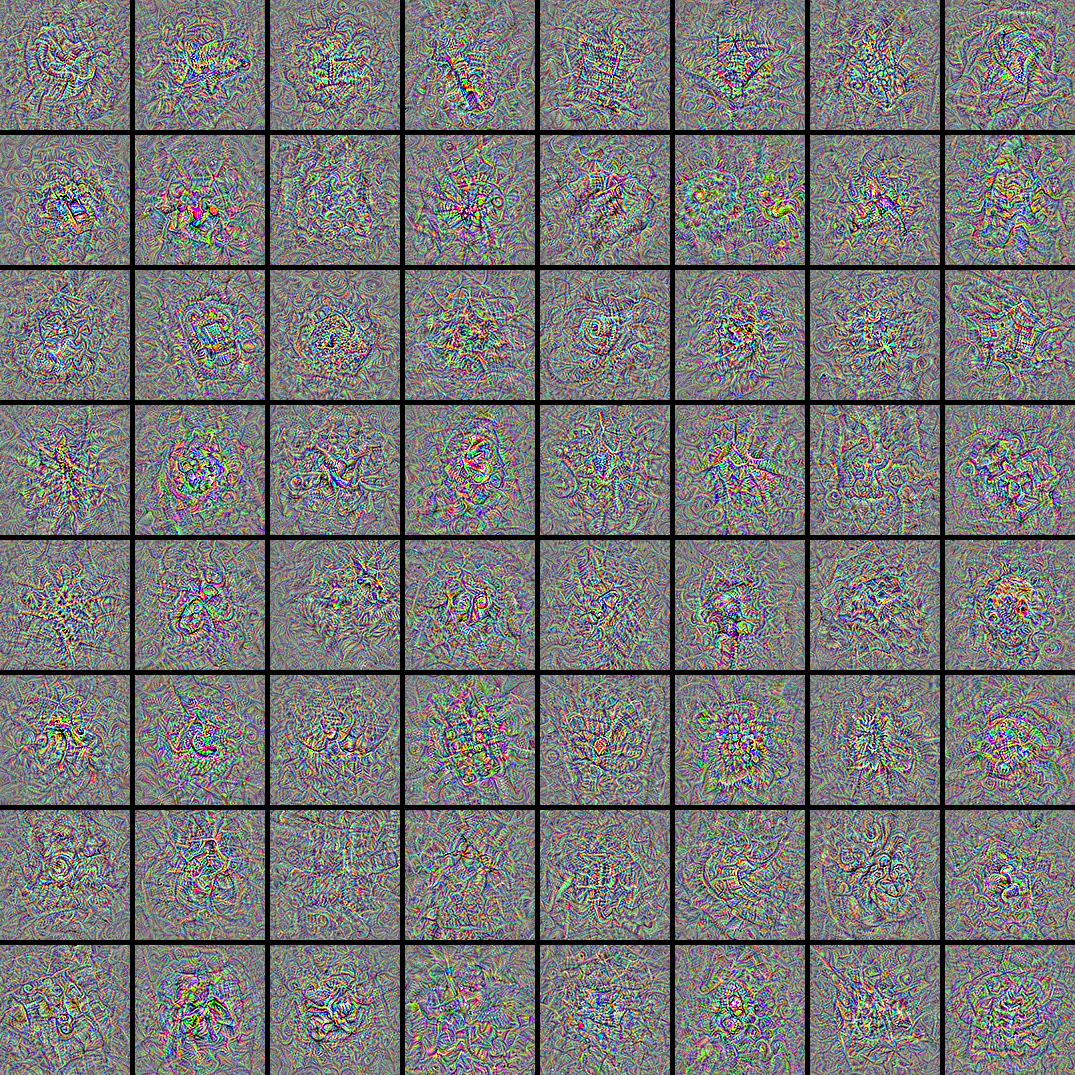

In [22]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

**It is almost impossible to interpret what are the patterns that the network look on this data. Maybe in some data this method could be more usefull**

It would be more useful if we could see the filters that contributed most to a particular ranking. I will look into how this can be done. This in theory can be solved with this technique (Filter Maximization) but applied in a different way.